# Comparison of the finite difference solver for the Mason-Weaver to Fipy finite volume solver

by Lancelot Barthe and Martinus Werts, october 2020


Here, we briefly compare the numerical solution of the Mason-Weaver equation obtained via our finite-difference solver to the solution from the [Fipy](https://www.ctcms.nist.gov/fipy/) finite-volume method.

We evaluate the solution for one typical case, and show that the results from our solver and those from Fipy are quite close, providing a cross-check between these solvers for the Mason-Weaver equation.

This Jupyter notebook requires the [Fipy](https://www.ctcms.nist.gov/fipy/) library to be installed (in case you would like to re-evaluate the notebook), in addition to Numpy and Matplotlib. Also, the finite-difference solver module `masonweaver_FDsolver.py` is required; it should be placed in the same folder as the notebook (or on the Python search path).

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
import fipy as fp
from masonweaver_FDsolver import MWsoln 

In [2]:
print('Python version: ', sys.version)

Python version:  3.8.5 | packaged by conda-forge | (default, Jul 31 2020, 02:39:48) 
[GCC 7.5.0]


In [3]:
print('Fipy version: ', fp.__version__)
print('Fipy matrix solver: ', fp.DefaultSolver)

Fipy version:  3.4.2.1
Fipy matrix solver:  <class 'fipy.solvers.petsc.linearGMRESSolver.LinearGMRESSolver'>


## Define the system

First, define constants and the liquid and nanoparticle parameters.

In [4]:
k_B = 1.380649e-23 # Boltzmann constant [J.K^-1]
g = 9.81 # gravitational constant [m.s^-2]

T = 298. # nanoparticle's solution temperature [°K]
phi_init = 1. # initial solution concentration [a.u. / relative concentration]

rho_f = 997.086 # fluid mass density [kg.m^-3] at 298K
eta = 0.000893 # fluid viscosity [N.m^-2.s] at 298K

rho_p = 19320. # particle mass density [kg.m^-3] (GOLD)
a = 25e-9 # spherical particle radius [m]

Compute diffusion coefficient, sedimentation coefficient and derived parameters.

In [5]:
f = 6*np.pi*eta*a # the drag coefficient [.]
m_b = (4/3)*np.pi*(a**3)*(rho_p-rho_f) # buoyant mass [kg]
s = m_b / f # sedimentation coefficient [s]
D = k_B*T/f # diffusion coefficient [m^2.s^-1]

## Set parameters common to both finite-difference solver and Fipy

Spatial domain settings.

In [6]:
h = 1e-2 # chamber height [m] (1 cm)
nx = 500 # 1D domain with (nx+1) grid points (FD), or nx control volumes (FV)

Time settings. The Mason-Weaver finite-difference solver will generate an exponentially expanding time step: small steps in the beginning, larger steps toward the end.

In [7]:
t_final = 480000. # Define simulation time [s]
steps = 2001 # Define number of steps [.]difference

## Finite-difference solver `masonweaver_FDsolver.py`

First, we call the finite difference solver. This solver returns a 'solution' object, which contains the entire calculated solution, *i.e.* the evolution of the 1D concentration profile as a function of time, on the finite-difference grid.

In [8]:
T0 = time()
soln = MWsoln(z_max=h, t_end=t_final,
              J=nx, N=steps,
              D=D, 
              sg=s*g)
T_FDM = time() - T0

## Finite volume solver: Fipy

1. Geometry: define mesh

In [9]:
dx = h / nx  # grid spacing
mesh = fp.Grid1D(nx=nx, dx=dx) # linear structured grid

2. Additional physical parameters (other parameters already defined above)

In [10]:
v_term_scal = s*g # convection coefficient (terminal velocity) [m.s_^-1] => scalar
v_term = (v_term_scal,) # Cast terminal velocity in vector shape 

3. Time grid

For the Fipy solution, we take the same time grid as used by the finite-difference solver. We need to supply the sizesof each time step to the solver

In [11]:
t_FVM = soln.t
timeStepDuration = t_FVM[1:] - t_FVM[:-1]
# check that time-steps are identical between FVM and FDM
assert np.allclose(timeStepDuration[:], soln.t[1:]-soln.t[:-1]), 'Incompatible time grids'

4. Cell variable, initial condition

In [12]:
phi = fp.CellVariable(name="Concentration",
                      mesh = mesh, value = phi_init )

5. Boundary conditions

We use the intrinsic no flux boundary conditions in Fipy.

These are used by Fipy by default.

In [13]:
print(' Default No Flux conditions are being used in this case ')

 Default No Flux conditions are being used in this case 


6. Define the PDE (Mason-Weaver diffusion-sedimentation)

In [14]:
eqX = fp.TransientTerm() == fp.DiffusionTerm(coeff=D) \
                            + fp.ExponentialConvectionTerm(coeff=v_term)

7. Now, go solve, Fipy.

In [15]:
# reserve space for storing Fipy solution
phi_sol = np.zeros([nx,steps]) # Initialize concentration solution vector as a function of time and space

In [16]:
#%% Solve PDE and store solution
T0 = time()
phi_sol[:,0] = phi.value # Store initial concentraton 
for step in range(1,steps):
    eqX.solve(var=phi, dt=timeStepDuration[step-1])
    phi_sol[:,step]=phi.value
T_FVM = time() - T0

## Comparison of present finite-difference solver to Fipy finite volume solver

In [17]:
print('Finite-difference computation time : {0:.2f} s'.format(T_FDM))
print('Fipy finite-volume computation time: {0:.2f} s'.format(T_FVM))

Finite-difference computation time : 1.43 s
Fipy finite-volume computation time: 19.00 s


With the results for both solvers stored in memory, we are in a position to compare both solvers.

First, we extract the spatial coordinates (1D: height) and time points for both methods to allow direct comparison

In [18]:
x_FDM = soln.z
x_FVM = mesh.cellCenters[0].value 

In [19]:
t_FDM = soln.t

The finite-difference solution 'samples' the solution at the boundaries and at evenly spaced points between them, whereas the finite-volume solution gives the average concentration in each volume element (cell), best considered at the center of of each cell.

In order to compare both, we interpolate the finite-difference solution (zero-order polynomial) to obtain the values at the positions of the finite-volume cell centers.

In [20]:
soln.c_resample = (soln.c[:-1,:] + soln.c[1:,:])/2
soln.z_resample = (soln.z[:-1] + soln.z[1:])/2

Check that the interpolated finite-difference solution point coincide with the finite volume cell centers.

In [21]:
assert np.allclose(soln.z_resample, x_FVM), "Incompatible grids"

Create references with coherent names, in order to facilitate further handling of data.

In [22]:
phi_sol_FDM = soln.c_resample
x_FDM = soln.z_resample

### (Numerical) mass conservation

As expected, Fipy's finite-volume method beautifully conserves mass (when using the default 'no flux' boundary conditions).

As already mentioned in our paper ([doi:10.1002/ppsc.201700095](https://doi.org/10.1002/ppsc.201700095)), the finite-difference solver has a slight mass increase, which levels off as the equilibrium steady-state solution is reached.

In [23]:
mass_cons_FDM = np.zeros(steps)
mass_cons_FVM = np.zeros(steps)

for i in range (0,steps):
    mass_cons_FVM[i] = np.sum(phi_sol[:,i])
    mass_cons_FDM[i] = np.sum(phi_sol_FDM[:,i])    

(460.0, 540.0)

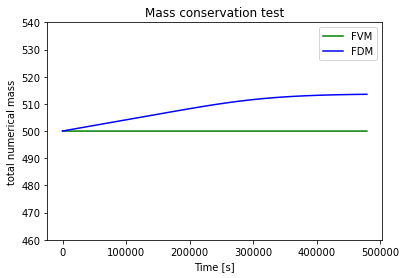

In [24]:
plt.plot(t_FVM[:-1], mass_cons_FVM,'g', label='FVM')
plt.plot(t_FDM[:-1], mass_cons_FDM,'b', label='FDM')
plt.xlabel('Time [s]')
plt.ylabel('total numerical mass')
plt.title('Mass conservation test')
plt.legend()
plt.ylim(460.0, 540.0)

### Direct comparison of selected concentration profiles at different times

Initial condition:

Perfect agreement between both methods! :-)

(0.0, 0.01)

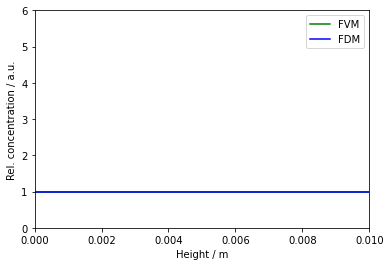

In [25]:
plt.plot(x_FVM, phi_sol[:,0], 'g',label = "FVM")
plt.plot(x_FDM[:], phi_sol_FDM[:,0],'b',label = "FDM")
plt.xlabel('Height / m')
plt.ylabel('Rel. concentration / a.u.')
plt.legend()
plt.ylim(0.0,6.0)
plt.xlim(0.0,h)

Intermediate (transient) solutions:

The curves between FD and Fipy are almost identical (perfect overlap when displaying on screen). See below for relative deviation between both methods

(0.0, 0.01)

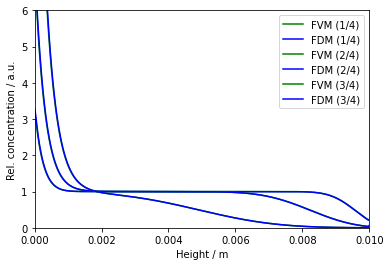

In [26]:
plt.plot(x_FVM, phi_sol[:,500], 'g',label = "FVM (1/4)")
plt.plot(x_FDM[:], phi_sol_FDM[:,500],'b',label = "FDM (1/4)")
plt.plot(x_FVM, phi_sol[:,1000], 'g',label = "FVM (2/4)")
plt.plot(x_FDM[:], phi_sol_FDM[:,1000],'b',label = "FDM (2/4)")
plt.plot(x_FVM, phi_sol[:,1500], 'g',label = "FVM (3/4)")
plt.plot(x_FDM[:], phi_sol_FDM[:,1500],'b',label = "FDM (3/4)")

plt.xlabel('Height / m')
plt.ylabel('Rel. concentration / a.u.')
plt.legend()
plt.ylim(0.0,6.0)
plt.xlim(0.0,h)

Last calculated time-point (close to equilibrium, but not quite yet):

(0.0, 0.01)

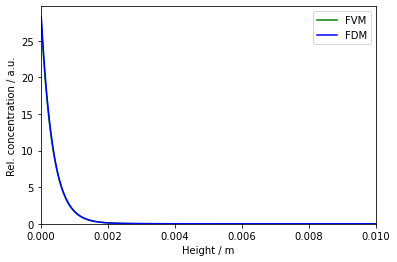

In [27]:
plt.plot(x_FVM, phi_sol[:,-1], 'g',label = "FVM")
plt.plot(x_FDM[:], phi_sol_FDM[:,-1],'b',label = "FDM")

plt.xlabel('Height / m')
plt.ylabel('Rel. concentration / a.u.')
plt.legend()
plt.ylim(ymin = 0.0)
plt.xlim(0.0,h)

We can see the small differences between FDM and FVM solutions by calculating the relative deviation between the two.

In [28]:
eps_500 = (phi_sol_FDM[0:nx,500] - phi_sol[:,500])/phi_sol_FDM[0:nx,500]
eps_1000 = (phi_sol_FDM[0:nx,1000] - phi_sol[:,1000])/phi_sol_FDM[0:nx,1000]
eps_1500 = (phi_sol_FDM[0:nx,1500] - phi_sol[:,1500])/phi_sol_FDM[0:nx,1500]
eps_2000 = (phi_sol_FDM[0:nx,2000] - phi_sol[:,2000])/phi_sol_FDM[0:nx,2000]
eps_final = (phi_sol_FDM[0:nx,-1] - phi_sol[:,-1])/phi_sol_FDM[0:nx,-1]

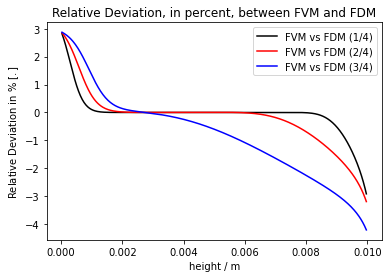

In [29]:
plt.plot(x_FVM[1:-1],eps_500[1:-1]*100.,'k',label='FVM vs FDM (1/4)')
plt.plot(x_FVM[1:-1],eps_1000[1:-1]*100.,'r',label='FVM vs FDM (2/4)')
plt.plot(x_FVM[1:-1],eps_1500[1:-1]*100.,'b',label='FVM vs FDM (3/4)')
plt.title('Relative Deviation, in percent, between FVM and FDM')
plt.xlabel('height / m')
plt.ylabel('Relative Deviation in % $[.]$')
plt.legend()

At the final time, the relative deviation clearly shows the numerical mass increase in the finite-difference scheme. Note that the relative deviation 'exaggerates' the deviation between both curves: the largest deviations occur in areas where the solution variable is close to zero.

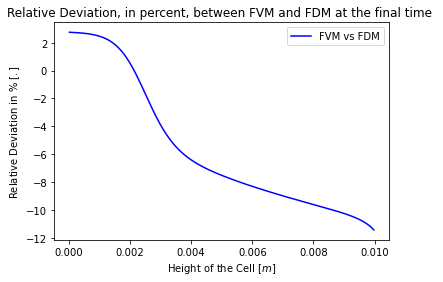

In [30]:
plt.plot(x_FVM[1:-1],eps_final[1:-1]*100.,'b',label='FVM vs FDM')
plt.title('Relative Deviation, in percent, between FVM and FDM at the final time ')
plt.xlabel('Height of the Cell $[m]$')
plt.ylabel('Relative Deviation in % $[.]$')
plt.legend()

## Conclusion

For this typical case, there is close agreement between the numerical solutions of the Mason-Weaver problem obtained via our finite-difference solver and Fipy, respectively.

It may very well be possible to change the physical and computational parameters in this notebook and study the behaviour of both solvers in other cases.